In [1]:
import os
import numpy as np
import torch.backends.cudnn as cudnn
import torch
from torchvision import models
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import torch.autograd as autograd
from models import ConvolutionalBlock, ResidualBlock
from torch.utils.data import Dataset
import hickle as hkl
import utils
import xlwt
import xlrd
from xlutils.copy import copy
import time
import IPython.display as display
import matplotlib.pyplot as plt

In [2]:
# 接触图 + 碱基距离，构建6通道的输入
def make_input(imgs, distances): #imgs batchsize*1*40*40     distances batchsize*5
    dis = distances.unsqueeze(2).unsqueeze(3)
    dis = dis.repeat(1,1,40,40)
    data_input = torch.cat((imgs,dis),1)
    return data_input

# CGAN的数据集加载器
class xxyDataset(Dataset):
    def __init__(self):
        path = './data/GM12878/train_data_half.hkl'
        lo, hi, distance_chrome = hkl.load(path)
        lo = lo.squeeze()
        hi = hi.squeeze()
        lo = np.expand_dims(lo,axis=1)
        hi = np.expand_dims(hi,axis=1)
        
        self.sample_list = []
        for i in range(len(lo)):
            lr = lo[i]
            hr = hi[i]
            dist = abs(distance_chrome[i][0])
            label_one_hot = torch.zeros(5)
            label_one_hot[int(dist/40)]=1
            chrom = distance_chrome[i][1]
            self.sample_list.append([lr, hr, label_one_hot, chrom])
        print("dataset loaded : " + str(len(lo)) + '*' + str(len(lo[0])) + '*' + str(len(lo[0][0])) + '*' + str(len(lo[0][0][0])))
    def __getitem__(self, i):
        (lr_img, hr_img, distance_one_hot, chromosome) = self.sample_list[i]
        return lr_img, hr_img, distance_one_hot, chromosome
    def __len__(self):
        return len(self.sample_list)

# 计算梯度惩罚
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.cuda.FloatTensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = autograd.Variable(torch.cuda.FloatTensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# CGAN的生成器，输入为6通道
class Generator(nn.Module):
    def __init__(self, kernel_size=3, n_channels=64, n_blocks=5):
        super(Generator, self).__init__()
        self.conv_block1 = ConvolutionalBlock(in_channels=6, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=False, activation='relu')
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(kernel_size=kernel_size, n_channels=n_channels) for i in range(n_blocks)])
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels,
                                              kernel_size=kernel_size,
                                              batch_norm=True, activation=None)
        self.conv_block3 = ConvolutionalBlock(in_channels=n_channels, out_channels=128, kernel_size=kernel_size,
                                              batch_norm=False, activation=None)
        self.conv_block4 = ConvolutionalBlock(in_channels=128, out_channels=256, kernel_size=kernel_size,
                                              batch_norm=False, activation=None)
        self.conv_block5 = ConvolutionalBlock(in_channels=256, out_channels=1, kernel_size=1,
                                              batch_norm=False, activation='tanh')

    def forward(self, lr_imgs):
        output = self.conv_block1(lr_imgs)  # (batch_size, 1, 40, 40)
        residual = output
        output = self.residual_blocks(output)
        output = self.conv_block2(output)
        output = output + residual
        output = self.conv_block3(output)
        output = self.conv_block4(output)
        sr_imgs = self.conv_block5(output)
        return sr_imgs

# CGAN的鉴别器，输入为6通道
class Discriminator(nn.Module):
    
    def __init__(self, kernel_size=3, n_channels=64):
        super(Discriminator, self).__init__()
        layers = list()
        layers.append(ConvolutionalBlock(in_channels=6, out_channels=n_channels, kernel_size=kernel_size, 
                                         stride=1, batch_norm=False, activation='LeakyReLu'))
        layers.append(ConvolutionalBlock(in_channels=64, out_channels=n_channels, kernel_size=kernel_size,
                                         stride=2, batch_norm=True, activation='LeakyReLu'))
        layers.append(ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                         stride=1, batch_norm=True, activation='LeakyReLu'))
        layers.append(ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                         stride=2, batch_norm=True, activation='LeakyReLu'))
        layers.append(ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                         stride=1, batch_norm=True, activation='LeakyReLu'))
        layers.append(ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                         stride=2, batch_norm=True, activation='LeakyReLu'))
        layers.append(ConvolutionalBlock(in_channels=n_channels, out_channels=128, kernel_size=kernel_size,
                                         stride=1, batch_norm=True, activation='LeakyReLu'))
        # 固定输出大小
        # layers.append(nn.AdaptiveAvgPool2d((6, 6)))
        layers.append(nn.Flatten())
        layers.append(nn.Linear(128*5*5, 512))
        layers.append(nn.LeakyReLU(0.2))
        layers.append(nn.Linear(512, 1))
        #layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)
    def forward(self, imgs):
        result = self.net(imgs)
        return result

In [3]:
# 设定使用的GPU的编号
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.cuda.set_device(0)
global checkpoint, start_epoch

# 生成器模型参数
kernel_size_g = 3         # 中间层卷积的核大小
n_channels_g = 64         # 中间层通道数
n_blocks_g = 5            # 残差模块数量

# 判别器模型参数
kernel_size_d = 3  # 所有卷积模块的核大小
n_channels_d = 64  # 模块的通道数

# 学习参数
batch_size = 128     # 批大小
start_epoch = 1     # 迭代起始位置
epochs = 30000         # 迭代轮数
checkpoint = None#"./result_cgan/checkpoint_epoch0375.pth"
workers = 1         # 加载数据线程数量
lr = 1e-4           # 学习率   动态调整学习率
lr_adj_1 = 0.1        # 学习率调整乘子
lr_adj_2 = 0.5        # 学习率调整乘子
lr_adj_3 = 0.1
lamda_gp = 0       # GP乘子
g_adversarial_ratio = 0.5 # 对抗损失乘子
tv_loss_ratio = 0.166666       # TV损失乘子
mse_loss_ratio = 0.166666      # MSE损失乘子
vgg_loss_ratio = 0.166666     # VGG损失乘子
    
# 设备参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True    # 对卷积进行加速

In [4]:
# 创建xls表格，用于记录损失收敛情况和绘制收敛曲线
if os.path.exists('./log_cgan.xls'):
        os.remove('./log_cgan.xls')
wb = xlwt.Workbook()
ws = wb.add_sheet('sheet0')
ws.write(0, 0, 'epoch')
ws.write(0, 1, 'MSE损失')
ws.write(0, 2, '生成器损失')
ws.write(0, 3, '判别器损失')
ws.write(0, 4, '用时（s）')
wb.save('./log_cgan.xls')

# 模型初始化
generator = Generator(kernel_size=kernel_size_g,
                      n_channels=n_channels_g,
                      n_blocks=n_blocks_g)
discriminator = Discriminator(kernel_size=kernel_size_d,
                              n_channels=n_channels_d)
vgg_16 = models.vgg16(pretrained=True).features

optimizer_g = torch.optim.Adam(params=filter(lambda p: p.requires_grad, generator.parameters()), lr=lr)
optimizer_d = torch.optim.Adam(params=filter(lambda p: p.requires_grad, discriminator.parameters()), lr=lr)

# 损失函数
tv_loss_criterion = utils.TVLoss()
mse_loss_criterion = nn.MSELoss()
adversarial_loss_criterion = nn.BCEWithLogitsLoss()
g_adversarial_loss_criterion = nn.BCEWithLogitsLoss()  # Generator
d_adversarial_loss_criterion = nn.BCEWithLogitsLoss()   # Discriminator

# 将数据移至默认设备
generator = generator.to(device)
discriminator = discriminator.to(device)
vgg_16 = vgg_16.to(device)
mse_loss_criterion = mse_loss_criterion.to(device)
tv_loss_criterion = tv_loss_criterion.to(device)
adversarial_loss_criterion = adversarial_loss_criterion.to(device)
g_adversarial_loss_criterion = g_adversarial_loss_criterion.to(device)
d_adversarial_loss_criterion = d_adversarial_loss_criterion.to(device)

# 加载断点
if checkpoint is not None:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    generator.load_state_dict(checkpoint['generator'])
    discriminator.load_state_dict(checkpoint['discriminator'])
    optimizer_g.load_state_dict(checkpoint['optimizer_g'])
    optimizer_d.load_state_dict(checkpoint['optimizer_d'])

# 加载数据集
train_dataset = xxyDataset()
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=workers,
                                           pin_memory=True)

dataset loaded : 30082*1*40*40


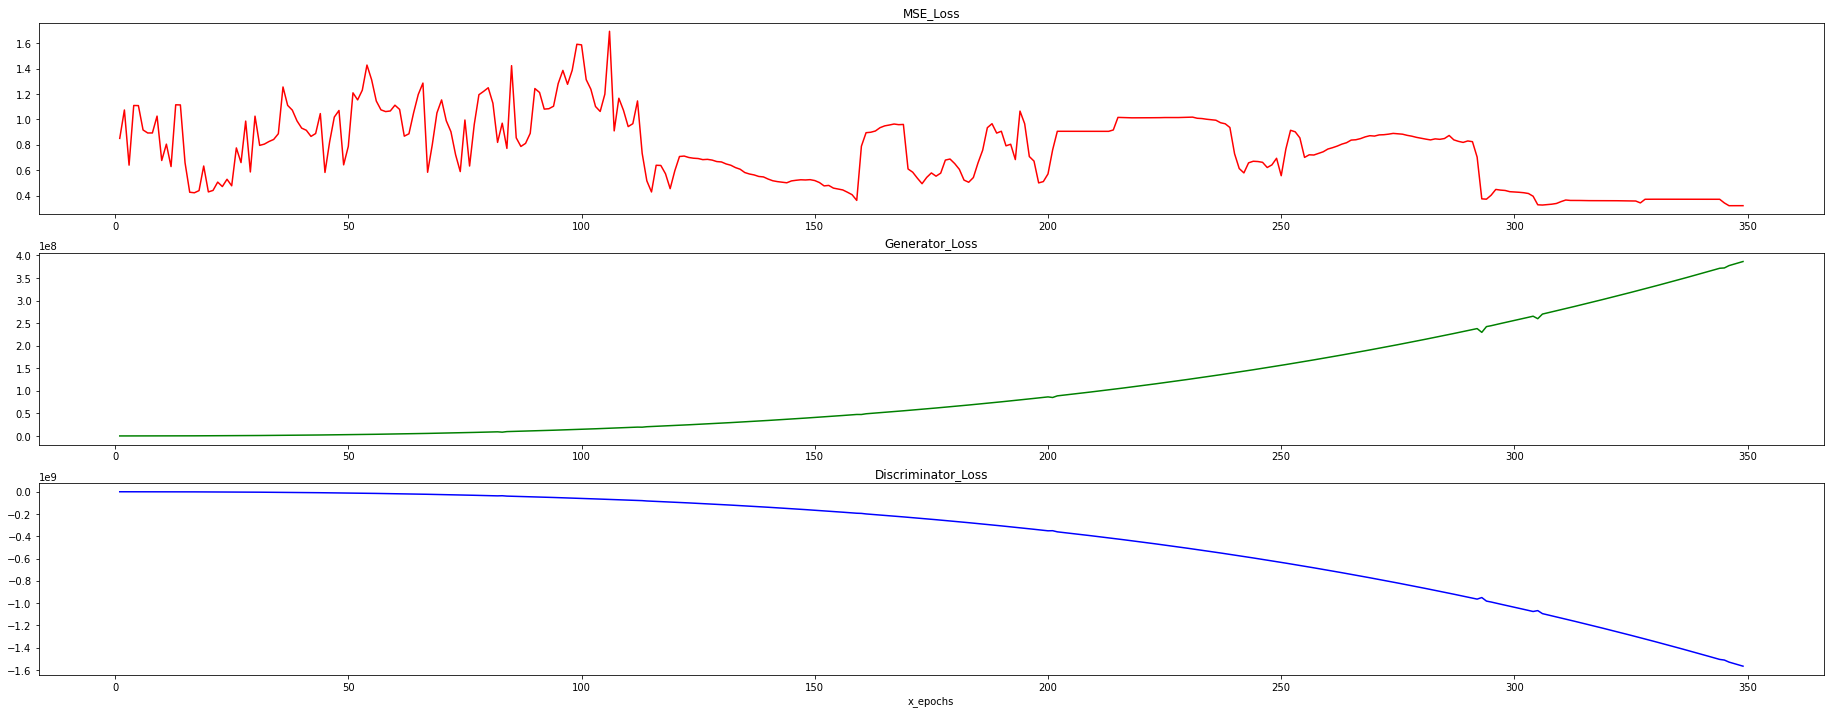

目前最好结果 ：第 -1 个epoch   Best_MSE = 0.0196
第 350 个epoch结束总用时  13.626 秒 average mse = 0.3209837738737354
第 351 个epoch结束总用时  13.629 秒 average mse = 0.3217697417741601
第 352 个epoch结束总用时  13.561 秒 average mse = 0.3200221087643143
第 353 个epoch结束总用时  13.595 秒 average mse = 0.32057634644127614
第 354 个epoch结束总用时  13.616 秒 average mse = 0.32115775393913437
第 355 个epoch结束总用时  13.580 秒 average mse = 0.3197852472708617
第 356 个epoch结束总用时  13.645 秒 average mse = 0.31966972255570464
第 357 个epoch结束总用时  13.589 秒 average mse = 0.3194208418060416
第 358 个epoch结束总用时  13.603 秒 average mse = 0.32046775360641927
第 359 个epoch结束总用时  13.651 秒 average mse = 0.3200353012880852
第 360 个epoch结束总用时  13.642 秒 average mse = 0.32124038880258615
第 361 个epoch结束总用时  13.674 秒 average mse = 0.3205430528306159
第 362 个epoch结束总用时  13.653 秒 average mse = 0.3207785653850831
第 363 个epoch结束总用时  13.655 秒 average mse = 0.32108971601779707


In [ ]:
# 开始逐轮训练
standard_MSE = 0.0196
best_MSE = 0.0196
best_epoch = -1
print("***开始训练***")
for epoch in range(start_epoch, epochs+1):
    if epoch == 500:  # 降低学习率
        utils.adjust_learning_rate(optimizer_g, lr_adj_1)
        utils.adjust_learning_rate(optimizer_d, lr_adj_1)
    if epoch == 1200:  # 降低学习率
        utils.adjust_learning_rate(optimizer_g, lr_adj_2)
        utils.adjust_learning_rate(optimizer_d, lr_adj_2)
    if epoch == 5000:  # 降低学习率
        utils.adjust_learning_rate(optimizer_g, lr_adj_3)
        utils.adjust_learning_rate(optimizer_d, lr_adj_3)
    generator.train()   # 开启训练模式：允许使用批样本归一化
    discriminator.train()
    vgg_16.eval()  # 使用vgg计算损失函数，不用更新vgg
    
    losses_c = utils.AverageMeter()  # 内容损失
    losses_a = utils.AverageMeter()  # 生成损失
    losses_d = utils.AverageMeter()  # 判别损失

    start_time = time.time()
    for batch, (lr_imgs, hr_imgs, distance, chromo) in enumerate(train_loader):
        lr_imgs = lr_imgs.type(torch.FloatTensor).to(device)
        hr_imgs = hr_imgs.type(torch.FloatTensor).to(device)
        distance = distance.to(device)
        
        G_input = make_input(lr_imgs, distance)
        D_input_real = make_input(hr_imgs, distance)
        
        # -----------------------1. 生成器更新----------------------------
        sr_imgs = generator(G_input)
        D_input_fake = make_input(sr_imgs, distance)
        sr_discriminated = discriminator(D_input_fake)
        
        
        #sr_imgs_vgg = torch.cat([sr_imgs,sr_imgs,sr_imgs],1)
        #hr_imgs_vgg = torch.cat([hr_imgs,hr_imgs,hr_imgs],1)
        
        #vgg_loss = mse_loss_criterion(vgg_16(sr_imgs_vgg),vgg_16(hr_imgs_vgg))
        #tv_loss = tv_loss_criterion(sr_imgs)
        mse_loss = mse_loss_criterion(sr_imgs, hr_imgs)
        g_adversarial_loss = -torch.mean(sr_discriminated)# 生成器希望生成的图像能够完全迷惑判别器，因此它的预期所有图片真值为1
        g_loss = g_adversarial_ratio*g_adversarial_loss + mse_loss_ratio*mse_loss# +tv_loss_ratio*tv_loss+ vgg_loss_ratio*vgg_loss

        # 后向传播
        optimizer_g.zero_grad()
        g_loss.backward()

        # 更新生成器参数
        optimizer_g.step()

        # 记录损失值
        losses_c.update(mse_loss.item(), G_input.size(0))
        losses_a.update(g_loss.item(), G_input.size(0))

        # -----------------------2. 判别器更新----------------------------
        # 判别器判断
        hr_discriminated = discriminator(D_input_real)
        sr_discriminated = discriminator(D_input_fake.detach())
        gradient_penalty = compute_gradient_penalty(discriminator, D_input_real.data, D_input_fake.data)
        
        d_loss = -torch.mean(hr_discriminated) + torch.mean(sr_discriminated) + lamda_gp * gradient_penalty
        
        # 后向传播
        optimizer_d.zero_grad()
        d_loss.backward()

        # 更新判别器
        optimizer_d.step()

        # 记录损失
        losses_d.update(d_loss.item(), D_input_fake.size(0)) 
    end_time = time.time()
    time_cost = format(end_time-start_time)  # 计算用时
    rb = xlrd.open_workbook(r'./log_cgan.xls')
    wb = copy(rb)
    ws = wb.get_sheet(0)
    ws.write(epoch, 0, epoch)
    ws.write(epoch, 1, losses_c.avg)
    ws.write(epoch, 2, losses_a.avg)
    ws.write(epoch, 3, losses_d.avg)
    ws.write(epoch, 4, time_cost)
    wb.save('./log_cgan.xls')
    
    # 遇到较好的结果，保存训练模型
    if losses_c.avg < standard_MSE:
        save_path = './result_cgan/checkpoint_epoch' + str(epoch).zfill(4) + '.pth'
        if os.path.exists(save_path):
            os.remove(save_path)
        if losses_c.avg < best_MSE:
            best_epoch = epoch
            best_MSE = losses_c.avg
        save_path = './result_cgan/best_checkpoint_epoch' + str(epoch).zfill(4) + '.pth'
        torch.save({
            'epoch': epoch,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_g': optimizer_g.state_dict(),
            'optimizer_d': optimizer_d.state_dict(),
        }, save_path)
    # 每25轮，保存训练模型
    if epoch % 25 == 0:
        save_path = './result_cgan/checkpoint_epoch' + str(epoch).zfill(4) + '.pth'
        torch.save({
            'epoch': epoch,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_g': optimizer_g.state_dict(),
            'optimizer_d': optimizer_d.state_dict(),
        }, save_path)
        # 清空单元格输出
        display.clear_output(wait=True)
        
        # 各项损失随epoch的收敛曲线
        rb = xlrd.open_workbook(r'./log_cgan.xls')
        ws = rb.sheet_by_index(0)
        x_epochs  = [float(ws.cell_value(i, 0)) for i in range(1, epoch)]
        mse       = [float(ws.cell_value(i, 1)) for i in range(1, epoch)]
        loss_a    = [float(ws.cell_value(i, 2)) for i in range(1, epoch)]
        loss_d    = [float(ws.cell_value(i, 3)) for i in range(1, epoch)]
        
        plt.figure(figsize=(32, 12))
        plt.subplot(3,1,1)
        plt.title("MSE_Loss")
        plt.plot(x_epochs, mse   , color = 'r',label="mse")
        plt.subplot(3,1,2)
        plt.title("Generator_Loss")
        plt.plot(x_epochs, loss_a, color = 'g',label="loss_generator")
        plt.subplot(3,1,3)
        plt.title("Discriminator_Loss")
        plt.plot(x_epochs, loss_d, color = 'b',label="loss_discriminator")
        plt.xlabel("x_epochs")
        #plt.legend(loc = "best")
        plt.show()
        print("目前最好结果 ：第 " + str(best_epoch) + " 个epoch"  + '   Best_MSE = ' + str(best_MSE))
    print("第 " + str(epoch) + " 个epoch结束" + '总用时  {:.3f} 秒'.format(end_time-start_time) + ' average mse = ' + str(losses_c.avg))
    # 内容损失 losses_c
    # 生成损失 losses_a
    # 判别损失 losses_d
    
print("第 " + str(best_epoch) + " 个epoch"  + '   Best_MSE = ' + str(best_MSE))
# -